In [6]:
import yfinance as yf
from fredapi import Fred
from config import get_fredapi_key

import numpy as np
import pandas as pd
import seaborn as sns

# define fred api (using my personal api key)
fred = Fred(api_key = get_fredapi_key())

# Data Acquision

- SP500: https://finance.yahoo.com/quote/%5EGSPC/
- MY10Y: https://fred.stlouisfed.org/series/DGS10
- CPI: https://fred.stlouisfed.org/series/CPIAUCSL
- M2SL: https://fred.stlouisfed.org/series/M2SL
- CSENT: https://fred.stlouisfed.org/series/UMCSENT
- IPM: https://fred.stlouisfed.org/series/IPMAN
- UNEMP: https://fred.stlouisfed.org/series/UNRATE

In [21]:
# define data
df_origin = pd.DataFrame()

### Data from yahoo finance
# download data as ticker "^GSPC" and convert to monthly data
sp500 = yf.download(['^GSPC'], start='1950-01-01').resample('M').last().reset_index()

# add "Date" (format: yyyy-mm) column to "df"
df_origin['Date'] = sp500['Date'].dt.strftime('%Y-%m')

# create new columns: "Year" and "Month" and add them to "df"
df_origin['Year'] = sp500['Date'].dt.year
df_origin['Month'] = sp500['Date'].dt.month

# add S&P500 data
df_origin['SP500'] = sp500['Close']

# calculate % change of YoY
df_origin['SP500_%YoY'] = df_origin['SP500'].pct_change(12)


### Data from Fred
# list of ids and column names of monthly data
ids = ['DGS10', 'CPIAUCSL', 'UMCSENT', 'IPMAN', 'HSN1F', 'UNRATE']
cols = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

# travering all pairs of ids and cols
for id, col in zip(ids, cols):
    # get the original data
    original = fred.get_series(id)
    # convert current index to column & change monthly data
    df_merge = original.resample('M').last().reset_index()
    # change column names
    df_merge.columns = ['Date', col]
    # update format of 'Date' column
    df_merge['Date'] = df_merge['Date'].dt.strftime('%Y-%m')

    # if column is not "UNEMP", add growth percentage
    if col != 'UNEMP':
        df_merge[f'{col}_%YoY'] = df_merge[col].pct_change(12)

    # merge two data frames
    df_origin = pd.merge(df_origin, df_merge, on='Date', how='left') # type: ignore


df_origin.head() # type: ignore

[*********************100%***********************]  1 of 1 completed


,Date,Year,Month,SP500,SP500_%YoY,MY10Y,MY10Y_%YoY,CPI,CPI_%YoY,M2,M2_%YoY,CSENT,CSENT_%YoY,IPM,IPM_%YoY,HOUSE,HOUSE_%YoY,UNEMP
0,1950-01,1950,1,17.049999,NaN,NaN,NaN,23.51,-0.020825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5
1,1950-02,1950,2,17.219999,NaN,NaN,NaN,23.61,-0.012547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.4
2,1950-03,1950,3,17.290001,NaN,NaN,NaN,23.64,-0.011292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.3
3,1950-04,1950,4,17.959999,NaN,NaN,NaN,23.65,-0.011288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8
4,1950-05,1950,5,18.780001,NaN,NaN,NaN,23.77,-0.005855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5


In [30]:
# download the original dataframe as csv
#df_origin.to_csv('original.csv', index=False)

# get original data from local file
df_origin = pd.read_csv('original.csv')
df_origin.head()

,Date,Year,Month,SP500,SP500_%YoY,MY10Y,MY10Y_%YoY,CPI,CPI_%YoY,CSENT,CSENT_%YoY,IPM,IPM_%YoY,HOUSE,HOUSE_%YoY,UNEMP
0,1950-01,1950,1,17.049999,NaN,NaN,NaN,23.51,-0.020825,NaN,NaN,NaN,NaN,NaN,NaN,6.5
1,1950-02,1950,2,17.219999,NaN,NaN,NaN,23.61,-0.012547,NaN,NaN,NaN,NaN,NaN,NaN,6.4
2,1950-03,1950,3,17.290001,NaN,NaN,NaN,23.64,-0.011292,NaN,NaN,NaN,NaN,NaN,NaN,6.3
3,1950-04,1950,4,17.959999,NaN,NaN,NaN,23.65,-0.011288,NaN,NaN,NaN,NaN,NaN,NaN,5.8
4,1950-05,1950,5,18.780001,NaN,NaN,NaN,23.77,-0.005855,NaN,NaN,NaN,NaN,NaN,NaN,5.5


# Data Clearning

In [31]:
# dropping rows based on any missing data
df = df_origin.dropna()

# groupby dataframe based on "Year" and check the count
df.groupby('Year').count()[['Date']]

,Date
Year,
1973,4
1974,4
1975,4
1976,4
1977,4
1978,12
1979,12
1980,12
1981,12


In [32]:
# Based on the observation, the data between 1973 and 1977 has missing in some months.
# Thus, removing data between 1973 and 1977.
df = df[df['Year'] >= 1978].reset_index(drop=True)
df.head()

,Date,Year,Month,SP500,SP500_%YoY,MY10Y,MY10Y_%YoY,CPI,CPI_%YoY,CSENT,CSENT_%YoY,IPM,IPM_%YoY,HOUSE,HOUSE_%YoY,UNEMP
0,1978-01,1978,1,89.250000,-0.125257,7.94,0.072973,62.7,0.068143,83.7,-0.037931,43.7471,0.068292,795.0,-0.036364,6.4
1,1978-02,1978,2,87.040001,-0.128030,8.04,0.079195,63.0,0.062395,84.3,-0.032147,43.9139,0.052995,791.0,-0.057211,6.3
2,1978-03,1978,3,89.209999,-0.093579,8.15,0.098383,63.4,0.063758,78.8,-0.095293,44.6899,0.056017,814.0,-0.066514,6.3
3,1978-04,1978,4,96.830002,-0.016355,8.24,0.106040,63.9,0.065000,81.6,-0.063146,45.3905,0.061632,864.0,0.081352,6.1
4,1978-05,1978,5,97.239998,0.011652,8.42,0.140921,64.5,0.071429,82.9,-0.080931,45.6235,0.058535,857.0,0.061958,6.0


# Data Observation

In [33]:
# define collections of columns
normal = []
YoY = []

cols = list(df.columns)[3:-1]
for i, col in enumerate(cols):
    if i % 2 == 0:
        normal.append(col)
    else:
        YoY.append(col)

# add 'UNEMP' for all collections 
normal.append('UNEMP')
YoY.append('UNEMP')

C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


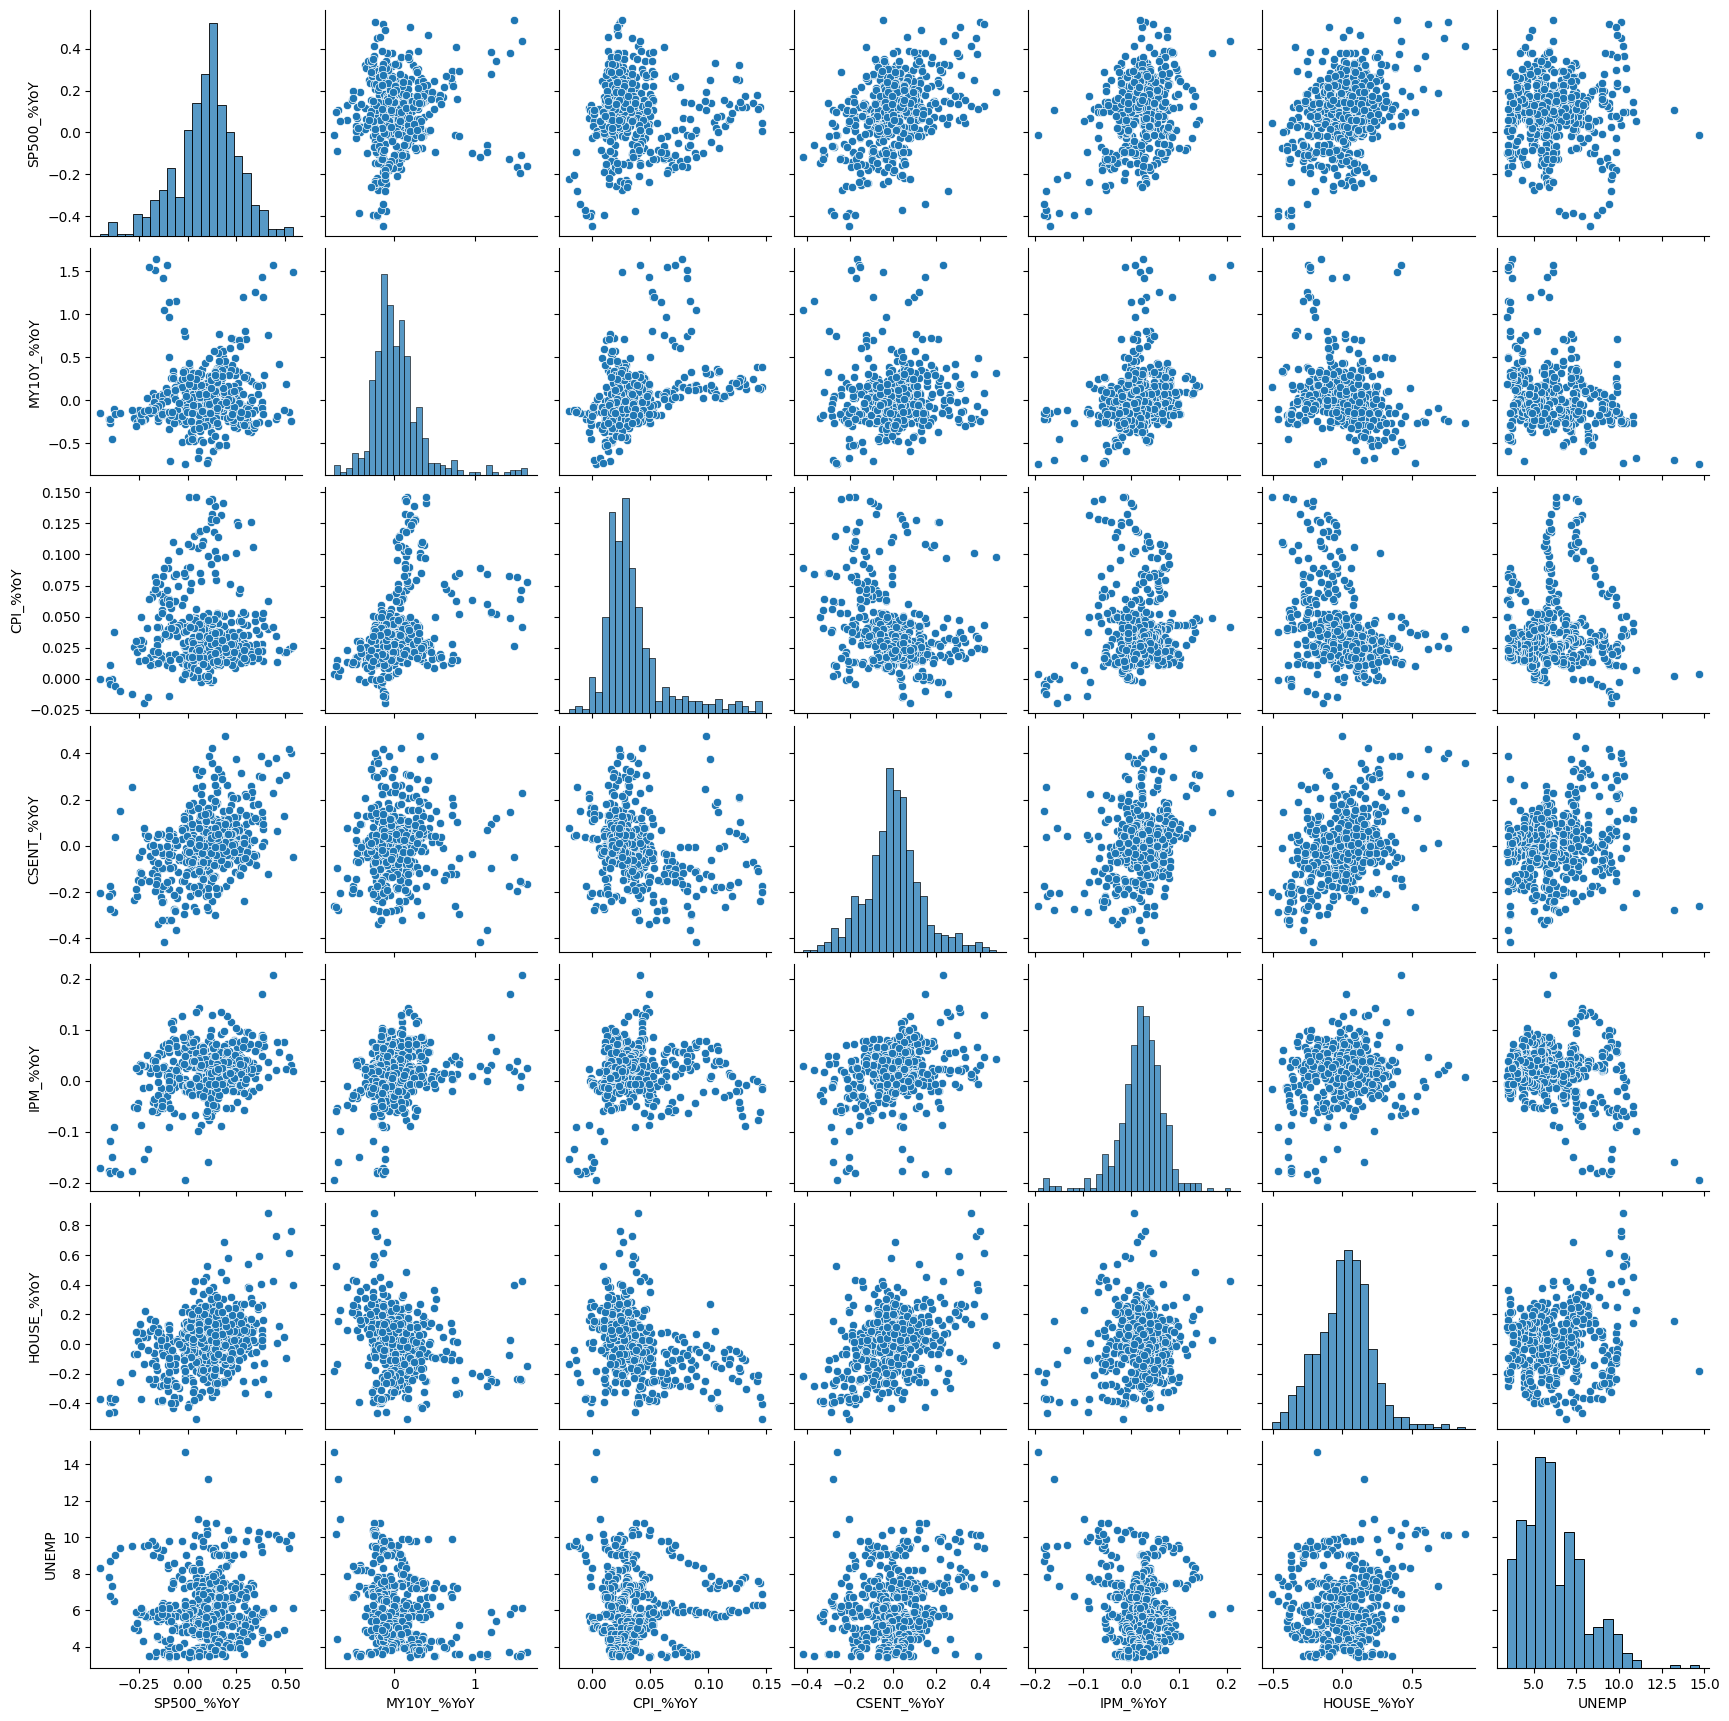

In [34]:
# check correlation ("normal" collections)
sns.pairplot(df[YoY])
